# Convert MIDI to numpy

In [ ]:
!pip install mido

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import string
import mido
import numpy as np
import pathlib
import math
import glob

In [ ]:
currentDirectory = "/content/drive/MyDrive/TF Music Generator/midiPiano/*.midi"
currentPattern = "/content/drive/MyDrive/TF Music Generator/midiPiano/*.midi"
fileNames = []
for currentFile in glob.glob(currentDirectory):
    fileNames.append(mido.MidiFile(str(currentFile)))
fileNames

[<midi file '/content/drive/MyDrive/TF Music Generator/midiPiano/MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--4.midi' type 1, 2 tracks, 18814 messages>,
 <midi file '/content/drive/MyDrive/TF Music Generator/midiPiano/MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav.midi' type 1, 2 tracks, 113255 messages>,
 <midi file '/content/drive/MyDrive/TF Music Generator/midiPiano/MIDI-Unprocessed_Schubert10-12_MID--AUDIO_17_R2_2018_wav.midi' type 1, 2 tracks, 86627 messages>]

In [ ]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [ ]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [ ]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [ ]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [ ]:
result_array = []
for i in fileNames:
    result_array.append(mid2arry(i))

In [ ]:
import matplotlib.pyplot as plt
# for i in range(len(result_array)):
#     plt.plot(range(result_array[i].shape[0]), np.multiply(np.where(result_array[i]>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
#     plt.title("Classic MIDI")
#     plt.show()

In [ ]:
min_res_shape = []
for i in range(len(fileNames)):
  min_res_shape.append(result_array[i].shape[0])
min_value_res = min(min_res_shape)

In [ ]:
r_arr = result_array[0][:min_value_res]
for i in range(1,len(fileNames)):
  r_arr = np.dstack((r_arr,result_array[i][:min_value_res]))
r_arr = np.array(r_arr, dtype=float)
# r_arr

In [ ]:
r_arr.shape

(642478, 88, 3)

In [ ]:
r_arr = r_arr[:408000]
r_arr.shape

(408000, 88, 3)

In [ ]:
del result_array[:]
result_array

[]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [ ]:
r_arr = r_arr.reshape(r_arr.shape[2], r_arr.shape[0], r_arr.shape[1])

In [ ]:
r_arr = np.true_divide(r_arr, 100)

In [ ]:
r_arr = r_arr.reshape(-1, r_arr.shape[2])
r_arr.shape

(1224000, 88)

In [ ]:
x_train_dec = []
y_train_dec = []

for i in range(int(r_arr.shape[0] / 120 - 120)):
  x_train_dec.append(r_arr[i*120 : (i+1)*120])
  y_train_dec.append(r_arr[(i+1)*120 : (i+2)*120])

x_train_dec = np.array(x_train_dec, dtype="object")
y_train_dec = np.array(y_train_dec, dtype="object")

In [ ]:
x_train_dec.shape

(10080, 120, 88)

In [ ]:
y_train_dec.shape

(10080, 120, 88)

In [ ]:
x_train_dec = x_train_dec.astype(float)
y_train_dec = y_train_dec.astype(float)

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(88, input_shape=(120, 88), return_sequences=True, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(88, input_shape=(120, 88), return_sequences=True, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['mae', 'accuracy'])

x_train_new = x_train_dec
y_train_new = y_train_dec

model_lstm = model.fit(x_train_new, y_train_new, epochs = 20)
model_lstm

Epoch 1/20
315/315 [==============================] - 51s 156ms/step - loss: 8.0510 - mae: 0.3376 - accuracy: 0.0158
Epoch 2/20
315/315 [==============================] - 49s 157ms/step - loss: 7.7006 - mae: 0.1380 - accuracy: 0.0683
Epoch 3/20
315/315 [==============================] - 50s 160ms/step - loss: 7.0673 - mae: 0.0382 - accuracy: 0.1872
Epoch 4/20
315/315 [==============================] - 49s 157ms/step - loss: 6.6714 - mae: 0.0232 - accuracy: 0.2554
Epoch 5/20
315/315 [==============================] - 56s 177ms/step - loss: 6.5278 - mae: 0.0191 - accuracy: 0.2940
Epoch 6/20
315/315 [==============================] - 49s 156ms/step - loss: 6.3866 - mae: 0.0171 - accuracy: 0.3129
Epoch 7/20
315/315 [==============================] - 49s 157ms/step - loss: 6.3050 - mae: 0.0160 - accuracy: 0.3244
Epoch 8/20
315/315 [==============================] - 51s 160ms/step - loss: 6.2628 - mae: 0.0153 - accuracy: 0.3382
Epoch 9/20
315/315 [==============================] - 50s 160ms/

In [ ]:
# model.save_weights('/content/drive/MyDrive/ML Music Generator/weights/weights')

In [ ]:
model.save('/content/drive/MyDrive/TF Music Generator/modelLstmFinal/predict_model.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TF Music Generator/modelLstmFinal/predict_model.model/assets


In [ ]:
print(model_lstm.history.keys())

dict_keys(['loss', 'mae', 'accuracy'])


Text(0.5, 0, 'Epoch')

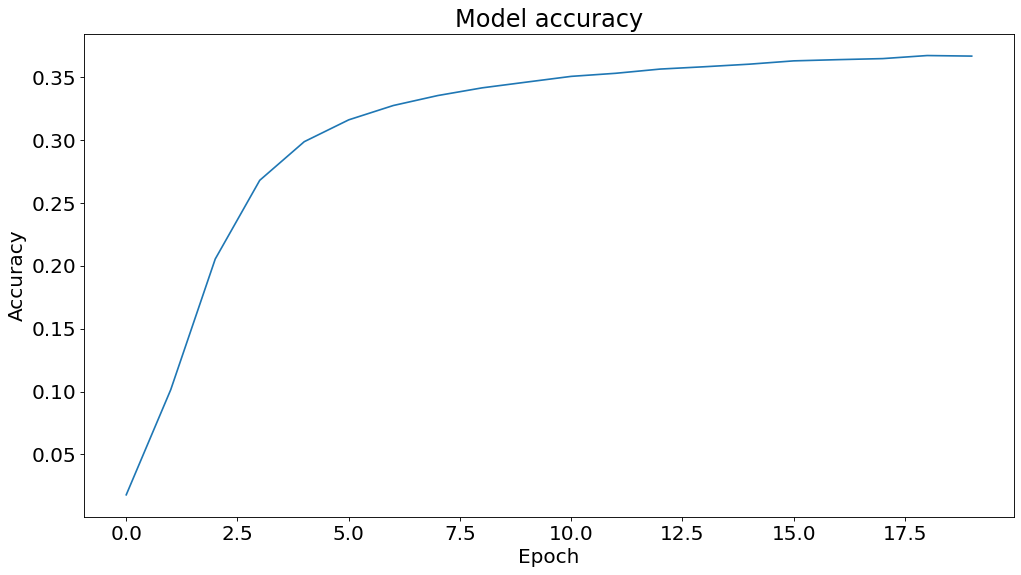

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})
figure(figsize=(15, 8), dpi=80)

plt.plot(model_lstm.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


Text(0.5, 0, 'Epoch')

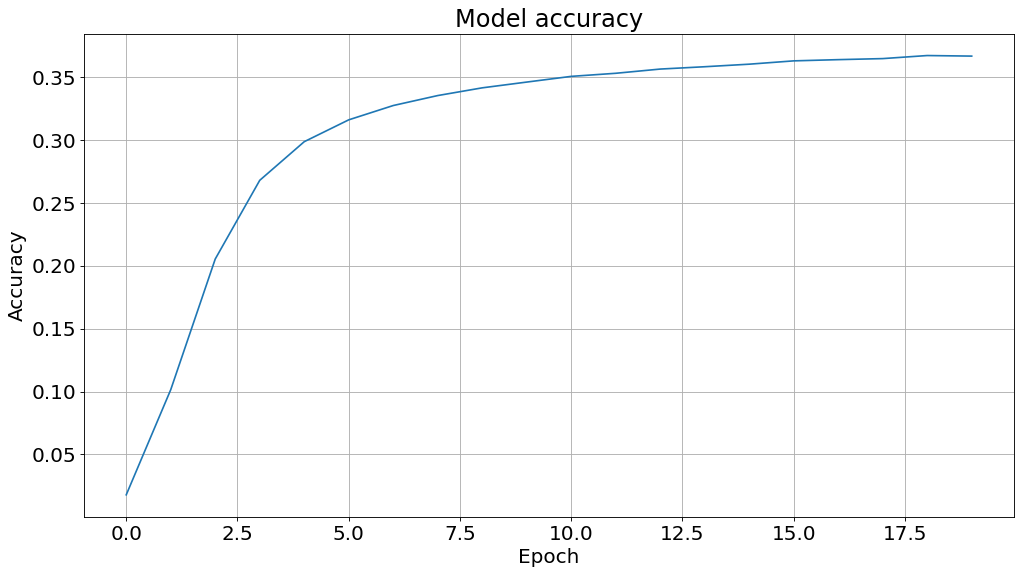

In [ ]:
plt.rcParams.update({'font.size': 18})
figure(figsize=(15, 8), dpi=80)
plt.grid()
plt.plot(model_lstm.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

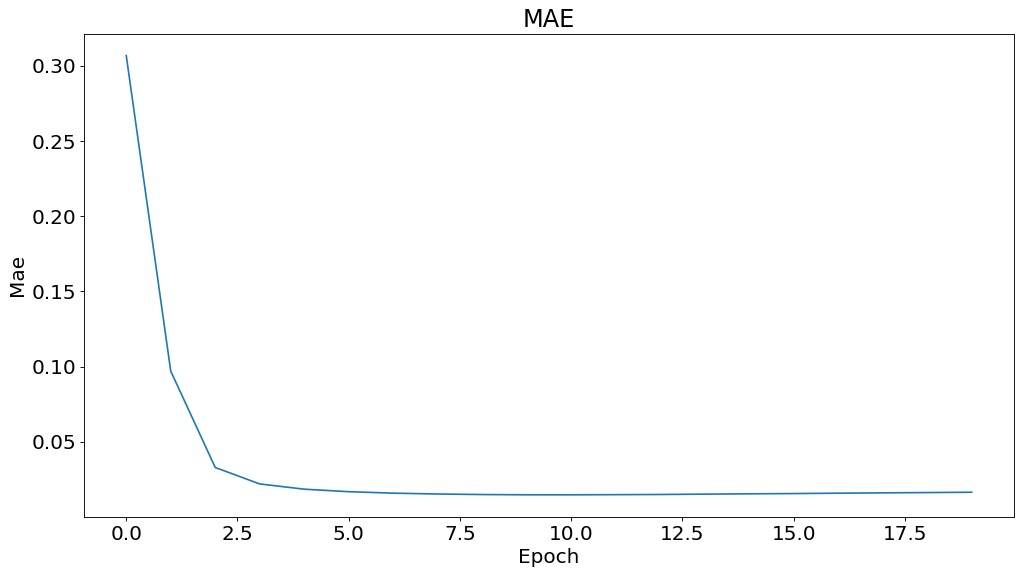

In [ ]:
plt.rcParams.update({'font.size': 18})
figure(figsize=(15, 8), dpi=80)

plt.plot(model_lstm.history['mae'])
plt.title('MAE')
plt.ylabel('Mae')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

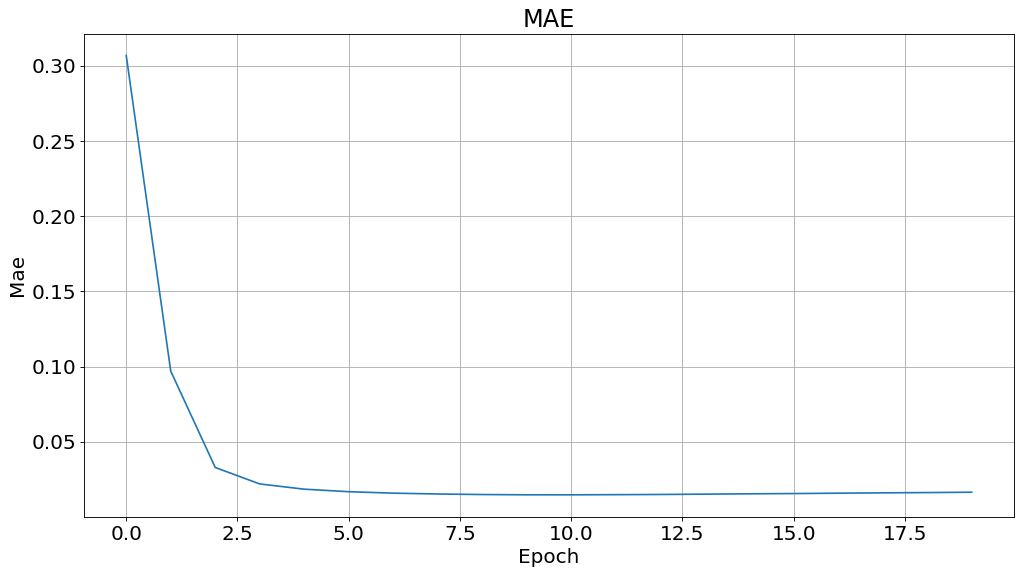

In [ ]:
plt.rcParams.update({'font.size': 18})
figure(figsize=(15, 8), dpi=80)
plt.grid()
plt.plot(model_lstm.history['mae'])
plt.title('MAE')
plt.ylabel('Mae')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

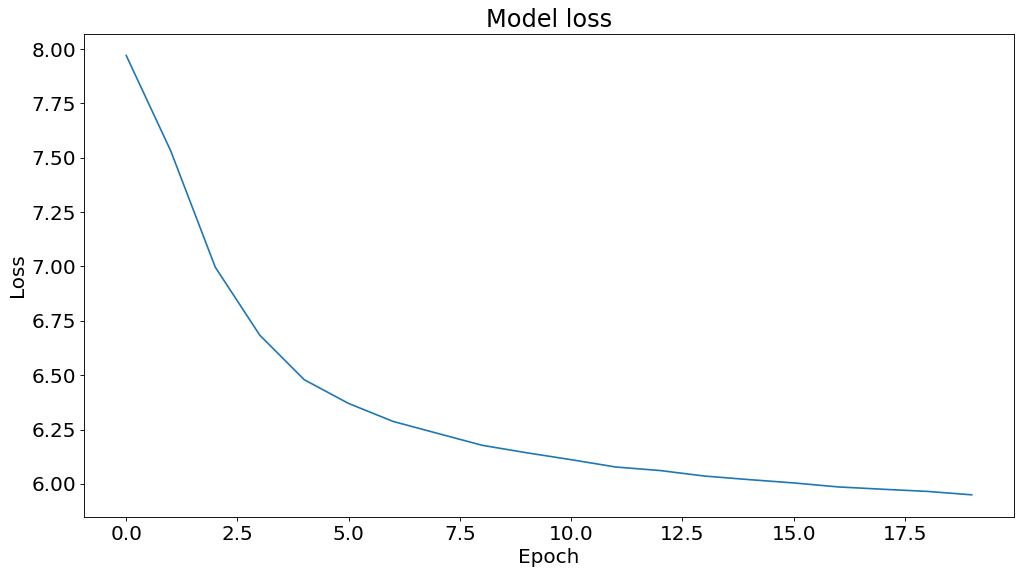

In [ ]:
plt.rcParams.update({'font.size': 18})
figure(figsize=(15, 8), dpi=80)

plt.plot(model_lstm.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

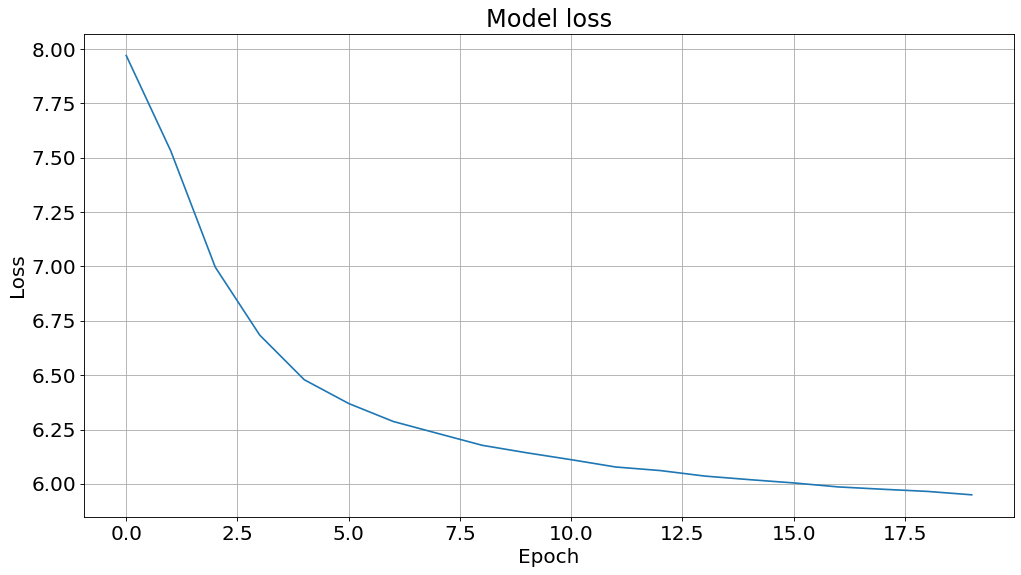

In [ ]:
plt.rcParams.update({'font.size': 18})
figure(figsize=(15, 8), dpi=80)
plt.grid()
plt.plot(model_lstm.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [ ]:
currentDirectory = "/content/drive/MyDrive/ML Music Generator/songs/Rockabye_new.mid"
currentPattern = "/content/drive/MyDrive/ML Music Generator/songs/Rockabye_new.mid"
fileNames = []
for currentFile in glob.glob(currentDirectory):
    fileNames.append(mido.MidiFile(str(currentFile)))
fileNames

[<midi file '/content/drive/MyDrive/ML Music Generator/songs/Rockabye_new.mid' type 1, 1 tracks, 624 messages>]

In [ ]:
train_array = []
for i in fileNames:
    train_array.append(mid2arry(i))

In [ ]:
train_min_res_shape = []
for i in range(len(fileNames)):
  train_min_res_shape.append(train_array[i].shape[0])
train_min_value_res = min(train_min_res_shape)

In [ ]:
train_r_arr = train_array[0][:train_min_value_res]
for i in range(1,len(fileNames)):
  train_r_arr = np.dstack((train_r_arr,train_array[i][:train_min_value_res]))
train_r_arr = np.array(train_r_arr, dtype=float)
train_r_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# train_r_arr = train_r_arr[:5000]
train_r_arr.shape

(5892, 88)

In [ ]:
train_r_arr[100]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [ ]:
C = np.where(train_r_arr > 0.001, 1, 0)

In [ ]:
model_train = tf.keras.models.load_model('/content/drive/MyDrive/TF Music Generator/model/predict_model.model')

In [ ]:
prediction = model_train.predict(C)

In [ ]:
D = np.where(prediction > 0.001, 1, 0)

In [ ]:
C.shape

(5892, 88)

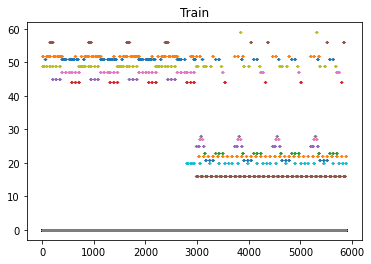

In [ ]:
plt.plot(range(C.shape[0]), np.multiply(np.where(C>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Train")
plt.show()

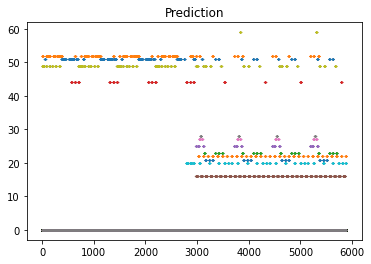

In [ ]:
plt.plot(range(prediction.shape[0]), np.multiply(np.where(prediction>0.1, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Prediction")
plt.show()

In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 17.3MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591954 sha256=20d355c6ca2c1d808515ace90301ecce9f9994b3870a67d23975993689f78b7b
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:
import pandas as pd
notes = pd.read_excel("/content/drive/MyDrive/ML Music Generator/notes.xls")
# notes

In [ ]:
import pathlib
import math
import pretty_midi

currentDirectory = "/content/drive/MyDrive/ML Music Generator/midiPiano/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi"
fileNames = []

a = []
b = []

i = 0 # number of files - 1
j = 0 # count of notes
J = []
for currentFile in glob.glob(currentDirectory):
    print(str(currentFile))
    fileNames.append(str(currentFile))

    midi_data = pretty_midi.PrettyMIDI(str(currentFile))
    for instrument in midi_data.instruments:
        print(i)
        for note in instrument.notes:
            for col in notes.columns:
                for row in range(11):
                    if notes[col][row] == note.pitch:
                        a.append(col)
                        b.append(row)
                        j += 1
    #                     print(col, row) 
    print(len(a))
    i += 1
    J.append(j)
    j = 0

/content/drive/MyDrive/ML Music Generator/midiPiano/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi
0
4991


In [ ]:
import pretty_midi
midi_data = pretty_midi.PrettyMIDI('/content/drive/MyDrive/ML Music Generator/midiPiano/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi')
print("duration:",midi_data.get_end_time())
print(f'{"note":>10} {"start":>10} {"end":>10}')
for instrument in midi_data.instruments:
    print("instrument:", instrument.program);
    for note in instrument.notes:
        print(f'{note.pitch:10} {note.start:10} {note.end:10}')

# Convert numpy to MIDI

In [ ]:
def arry2mid(ary, tempo):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [ ]:
D = D * 100
D[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 100,   0,   0, 100,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [ ]:
result_midi_array = D.astype(int)
result_midi_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
mid_new = arry2mid(result_midi_array, 500000)
mid_new.save('/content/drive/MyDrive/TF Music Generator/result_midi/piano_test_out.mid')

In [ ]:
import pretty_midi
midi_data = pretty_midi.PrettyMIDI('1.mid')
print("duration:",midi_data.get_end_time())
print(f'{"note":>10} {"start":>10} {"end":>10}')
for instrument in midi_data.instruments:
    print("instrument:", instrument.program);
    for note in instrument.notes:
        print(f'{note.pitch:10} {note.start:10} {note.end:10}')

In [ ]:
import pandas as pd
notes = pd.read_excel("notes.xls")
notes

,Octave,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B
0,-1,0,1,2,3,4,5,6,7,8,9,10,11
1,-1,12,13,14,15,16,17,18,19,20,21,22,23
2,0,24,25,26,27,28,29,30,31,32,33,34,35
3,1,36,37,38,39,40,41,42,43,44,45,46,47
4,2,48,49,50,51,52,53,54,55,56,57,58,59
5,3,60,61,62,63,64,65,66,67,68,69,70,71
6,4,72,73,74,75,76,77,78,79,80,81,82,83
7,5,84,85,86,87,88,89,90,91,92,93,94,95
8,6,96,97,98,99,100,101,102,103,104,104,106,107
9,7,108,109,110,111,112,113,114,115,116,117,118,119


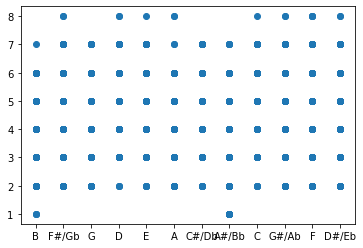

In [ ]:
a = []
b = []
midi_data = pretty_midi.PrettyMIDI('1.mid')
# print("duration:",midi_data.get_end_time())
# print(f'{"note":>10} {"start":>10} {"end":>10}')
for instrument in midi_data.instruments:
    for note in instrument.notes:
        for col in notes.columns:
            for row in range(11):
                if notes[col][row] == note.pitch:
                    a.append(col)
                    b.append(row)
#                     print(col, row)
plt.scatter(a, b)


In [ ]:
import pathlib
import math

currentDirectory = pathlib.Path('.')

# define the pattern
currentPattern = "midiPiano/*.midi"
fileNames = []

a = []
b = []

i = 0 # number of files - 1
j = 0 # count of notes
J = []
for currentFile in currentDirectory.glob(currentPattern):
    print(str(currentFile))
    fileNames.append(str(currentFile))

    midi_data = pretty_midi.PrettyMIDI(str(currentFile))
    for instrument in midi_data.instruments:
        print(i)
        for note in instrument.notes:
            for col in notes.columns:
                for row in range(11):
                    if notes[col][row] == note.pitch:
                        a.append(col)
                        b.append(row)
                        j += 1
    #                     print(col, row) 
    print(len(a))
    i += 1
    J.append(j)
    j = 0
    

k = 0
num = len(J)
# fig, axs = plt.subplots(num, num, figsize=(20, 10))
for row in range(num):
    k += J[row]
    
    
        

midiPiano/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.midi
0
7594
midiPiano/MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.midi
1
20562
midiPiano/MIDI-Unprocessed_Chamber4_MID--AUDIO_11_R3_2018_wav--1.midi
2
28600
midiPiano/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi
3
33591
midiPiano/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
4
37788


In [ ]:
from collections import defaultdict

res = defaultdict(list)

for i, j in zip(a, b):
    res[i].append(j)

In [ ]:
from collections import Counter
new_dict = []
for key in res.keys():
    new_dict.append(dict(Counter(res.get(key))))
new_dict

[{5: 1320, 4: 1163, 3: 732, 6: 441, 2: 249, 1: 3, 7: 22},
 {6: 1290, 5: 1485, 4: 1091, 3: 481, 2: 70, 7: 109, 8: 3},
 {5: 1293, 6: 882, 4: 853, 3: 359, 2: 79, 7: 64},
 {6: 1486, 5: 1359, 4: 723, 3: 203, 7: 297, 2: 5, 8: 16},
 {5: 1320, 6: 1388, 4: 913, 7: 145, 3: 325, 2: 20, 8: 4},
 {6: 818, 5: 1414, 4: 1063, 3: 473, 2: 87, 8: 2, 7: 24},
 {6: 1112, 4: 531, 5: 1055, 7: 243, 2: 9, 3: 146, 8: 16},
 {5: 721, 4: 688, 3: 299, 2: 108, 6: 276, 1: 12, 7: 49},
 {6: 670, 4: 394, 5: 616, 3: 144, 7: 201, 2: 6, 8: 31},
 {4: 655, 5: 815, 3: 267, 2: 70, 6: 481, 7: 71, 8: 2},
 {5: 535, 6: 462, 4: 300, 3: 151, 2: 19, 7: 91, 8: 5},
 {5: 789, 6: 728, 4: 553, 3: 215, 7: 143, 2: 26, 8: 9}]

In [ ]:
res.keys()

dict_keys(['B', 'F#/Gb', 'G', 'D', 'E', 'A', 'C#/Db', 'A#/Bb', 'C', 'G#/Ab', 'F', 'D#/Eb'])

In [ ]:
df = pd.DataFrame()
max_len = max(map(len, new_dict))
data = defaultdict(list)
for key in new_dict:
    data['0'].append(key.get(0))
    data['1'].append(key.get(1))
    data['2'].append(key.get(2))
    data['3'].append(key.get(3))
    data['4'].append(key.get(4))
    data['5'].append(key.get(5))
    data['6'].append(key.get(6))
    data['7'].append(key.get(7))
    data['8'].append(key.get(8))
    data['9'].append(key.get(9))
    data['10'].append(key.get(10))
    data['11'].append(key.get(11))
df1 = pd.DataFrame(data, index = ['B', 'F#/Gb', 'G', 'D', 'E', 'A', 'C#/Db', 'A#/Bb', 'C', 'G#/Ab', 'F', 'D#/Eb'])

df1.fillna(0, inplace=True)
df1

,0,1,2,3,4,5,6,7,8,9,10,11
B,0,3.0,249,732,1163,1320,441,22,0.0,0,0,0
F#/Gb,0,0.0,70,481,1091,1485,1290,109,3.0,0,0,0
G,0,0.0,79,359,853,1293,882,64,0.0,0,0,0
D,0,0.0,5,203,723,1359,1486,297,16.0,0,0,0
E,0,0.0,20,325,913,1320,1388,145,4.0,0,0,0
A,0,0.0,87,473,1063,1414,818,24,2.0,0,0,0
C#/Db,0,0.0,9,146,531,1055,1112,243,16.0,0,0,0
A#/Bb,0,12.0,108,299,688,721,276,49,0.0,0,0,0
C,0,0.0,6,144,394,616,670,201,31.0,0,0,0
G#/Ab,0,0.0,70,267,655,815,481,71,2.0,0,0,0


In [ ]:
df = df1.transpose()
df

,B,F#/Gb,G,D,E,A,C#/Db,A#/Bb,C,G#/Ab,F,D#/Eb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
2,249.0,70.0,79.0,5.0,20.0,87.0,9.0,108.0,6.0,70.0,19.0,26.0
3,732.0,481.0,359.0,203.0,325.0,473.0,146.0,299.0,144.0,267.0,151.0,215.0
4,1163.0,1091.0,853.0,723.0,913.0,1063.0,531.0,688.0,394.0,655.0,300.0,553.0
5,1320.0,1485.0,1293.0,1359.0,1320.0,1414.0,1055.0,721.0,616.0,815.0,535.0,789.0
6,441.0,1290.0,882.0,1486.0,1388.0,818.0,1112.0,276.0,670.0,481.0,462.0,728.0
7,22.0,109.0,64.0,297.0,145.0,24.0,243.0,49.0,201.0,71.0,91.0,143.0
8,0.0,3.0,0.0,16.0,4.0,2.0,16.0,0.0,31.0,2.0,5.0,9.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.sum().sum()

37788.0

In [ ]:
df_w = df / df.sum().sum()
df_w

,B,F#/Gb,G,D,E,A,C#/Db,A#/Bb,C,G#/Ab,F,D#/Eb
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000318,0.000000,0.000000,0.000000,0.000000
2,0.006589,0.001852,0.002091,0.000132,0.000529,0.002302,0.000238,0.002858,0.000159,0.001852,0.000503,0.000688
3,0.019371,0.012729,0.009500,0.005372,0.008601,0.012517,0.003864,0.007913,0.003811,0.007066,0.003996,0.005690
4,0.030777,0.028872,0.022573,0.019133,0.024161,0.028131,0.014052,0.018207,0.010427,0.017334,0.007939,0.014634
5,0.034932,0.039298,0.034217,0.035964,0.034932,0.037419,0.027919,0.019080,0.016301,0.021568,0.014158,0.020880
6,0.011670,0.034138,0.023341,0.039325,0.036731,0.021647,0.029427,0.007304,0.017730,0.012729,0.012226,0.019265
7,0.000582,0.002885,0.001694,0.007860,0.003837,0.000635,0.006431,0.001297,0.005319,0.001879,0.002408,0.003784
8,0.000000,0.000079,0.000000,0.000423,0.000106,0.000053,0.000423,0.000000,0.000820,0.000053,0.000132,0.000238
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'Вес каждой ноты')

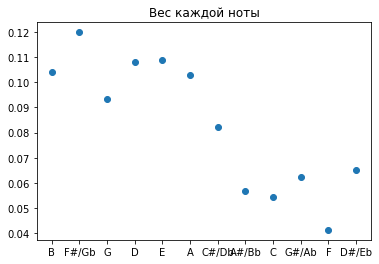

In [ ]:
x_axis = []
df_w_sum = []
for row in df_w.columns: 
    x_axis.append(row)
    df_w_sum.append(df_w[row][:].values.sum())
plt.scatter(x_axis, df_w_sum)
plt.title("Вес каждой ноты")
# df_w_sum

In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

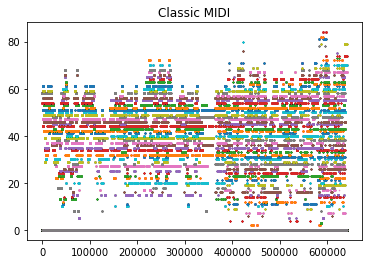

In [ ]:
plt.plot(range(result_array[0].shape[0]), np.multiply(np.where(result_array[0]>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Classic MIDI")
plt.show()

In [ ]:
split_percent = 0.80
split = int(split_percent*len(df))
split

9

In [ ]:
close_data = df["E"].values
close_data = close_data.reshape((-1,1))

close_train = close_data[:split]
close_test = close_data[split:]
close_train

array([[   0.],
       [   0.],
       [  20.],
       [ 325.],
       [ 913.],
       [1320.],
       [1388.],
       [ 145.],
       [   4.]])